In [1]:
# import requests
import torch
# import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
file = "nomes_br.csv"
words = []
with open(file, 'r', encoding='utf-8') as f:
    words = f.read().lower().splitlines()

file = "names.txt"
with open(file, 'r', encoding='utf-8') as f:
    for w in f.read().lower().splitlines():
        words.append(w) 
words = list(dict.fromkeys(words))
len(words), words[:10]

(57750,
 ['adao',
  'adelina',
  'adelson',
  'ademar',
  'ademir',
  'adenilson',
  'adilson',
  'adriana',
  'adriano',
  'adriele'])

In [3]:
#build the vocabulary os chars and mapping to/from integers
chars = ['.']+sorted(list(set(''.join(words))))
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [4]:
# build the dataset

block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10% , 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([348607, 3]) torch.Size([348607])
torch.Size([43537, 3]) torch.Size([43537])
torch.Size([43738, 3]) torch.Size([43738])


In [5]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [43]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)

W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * ((5/3) / ((n_emb*block_size) ** 0.5))
b1 = torch.randn(n_hidden,                          generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1
b2 = torch.randn(vocab_size,                        generator=g) * 0.1

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) 

parameters = [C, W1, W2, b2, b1, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [66]:
max_steps = 200000
batch_size = 32
lossi = []

In [45]:
# for i in range(max_steps):

# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

# foward pass
emb = C[Xb] # [32, 3, 2]
emb_cat = emb.view(emb.shape[0], -1)

# layer1
hprebn = emb_cat @ W1 + b1
#batchNorm layer
# bnstdi = hpreact.std(0, keepdim=True)
# hpreact = bngain * (hpreact - (bnmeani if calcBn else bnmean_running)) / (bnstdi if calcBn else bnstd_running)  + bnbias
bnmeani = 1/batch_size * hprebn.sum(0, keepdim=True) 
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(batch_size-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2

# if calcBn:
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

# h = torch.tanh(hpreact) # (32, 100)
# logits = h @ W2 + b2

# cross entropy loss (same as F.corss_entropy)
# loss = F.cross_entropy(logits, Yb)
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()


# backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
            norm_logits, logits_maxes, logits, h, hpreact, bnraw,
            bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, b1,
            emb_cat, emb]:
    t.retain_grad()
loss.backward()
loss
#update
# lr = 0.1 #if i < max_steps/2 else (0.01 if i < max_steps * 0.75 else 0.005) # lrs[i]
# for p in parameters:
#     p.data += -lr * p.grad

# track stats
# if i % 10000 == 0:
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
# lossi.append(loss.log10().item())

# print(loss.item())

tensor(3.6527, grad_fn=<NegBackward0>)

In [57]:
# logits.shape, logits.max(1, keepdim=True).values.shape
# F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) # HERE ZEROS AND ONES
# emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)



torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])


torch.Size([32, 3, 10])

In [59]:
# EX 1
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0 / batch_size
cmp('logprobs', dlogprobs, logprobs)

dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

dlogits_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logits_maxes', dlogits_maxes, logits_maxes)

dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes
cmp('logits', dlogits, logits)

dh = dlogits @ W2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp('h', dh, h)
cmp('w2', dw2, W2)
cmp('b2', db2, b2)

dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

dbndiff2 = (1.0/(batch_size-1))*torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff = bnvar_inv * dbnraw
dbndiff += (2 * bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

dbnmeani = (-dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff.clone()
dhprebn += 1.0/batch_size * torch.ones_like(hprebn) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

demb_cat = dhprebn @ W1.T
dw1 = emb_cat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp('emb_cat', demb_cat, emb_cat)
cmp('w1', dw1, W1)
cmp('b1', db1, b1)

demb = demb_cat.view(emb.shape)
cmp('emb', demb, emb)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [61]:
# EX: 2
dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= batch_size
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


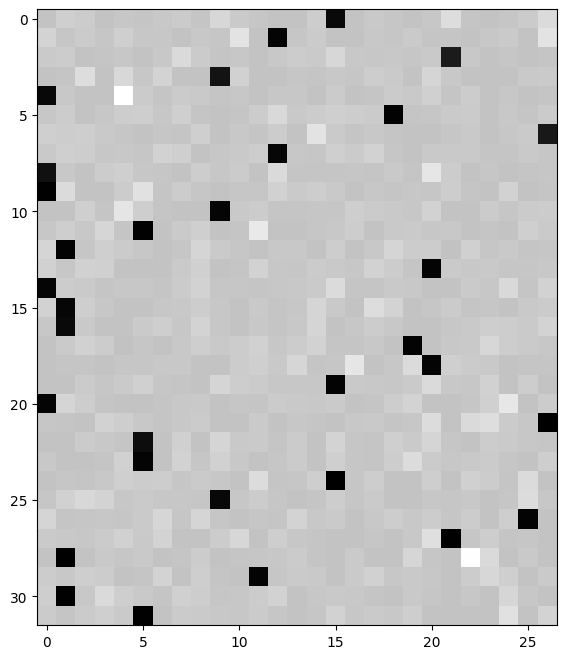

In [63]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [65]:
# Ex: 3
dhprebn = bngain*bnvar_inv/batch_size * (batch_size * dhpreact - dhpreact.sum(0) - batch_size/(batch_size-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [84]:
# EX: 4

#init
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)

W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * ((5/3) / ((n_emb*block_size) ** 0.5))
b1 = torch.randn(n_hidden,                          generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1
b2 = torch.randn(vocab_size,                        generator=g) * 0.1

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) 

parameters = [C, W1, W2, b2, b1, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

with torch.no_grad():
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # foward pass
        emb = C[Xb] # [32, 3, 2]
        emb_cat = emb.view(emb.shape[0], -1)

        # layer1
        hprebn = emb_cat @ W1 + b1
        # batchNorm layer
        bnmeani = 1/batch_size * hprebn.sum(0, keepdim=True) 
        bndiff = hprebn - bnmeani
        bndiff2 = bndiff ** 2
        bnvar = 1/(batch_size-1)*(bndiff2).sum(0, keepdim=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = bndiff * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-linearity
        h = torch.tanh(hpreact)
        # Linear layer 2
        logits = h @ W2 + b2

        logits_maxes = logits.max(1, keepdim=True).values
        norm_logits = logits - logits_maxes
        counts = norm_logits.exp()
        counts_sum = counts.sum(1, keepdim=True)
        counts_sum_inv = counts_sum**-1
        probs = counts * counts_sum_inv
        logprobs = probs.log()
        loss = -logprobs[range(batch_size), Yb].mean()

        # backward pass
        # for p in parameters:
        #     p.grad = None
        # loss.backward()
            
        # My Backprop
        dC, dw1, db1, dw2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
        # dlogprobs = torch.zeros_like(logprobs)
        # dlogprobs[range(batch_size), Yb] = -1.0 / batch_size
        # dprobs = (1.0 / probs) * dlogprobs
        # dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
        # dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
        # dcounts = counts_sum_inv * dprobs
        # dcounts += torch.ones_like(counts) * dcounts_sum
        # dnorm_logits = counts * dcounts
        # dlogits_maxes = (-dnorm_logits).sum(1, keepdim=True)
        # dlogits = dnorm_logits.clone()
        # dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes
        dlogits = F.softmax(logits, 1)
        dlogits[range(batch_size), Yb] -= 1
        dlogits /= batch_size

        dh = dlogits @ W2.T
        dw2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)

        # dbnraw = bngain * dhpreact
        # dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
        # dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
        # dbndiff2 = (1.0/(batch_size-1))*torch.ones_like(bndiff2) * dbnvar
        # dbndiff = bnvar_inv * dbnraw
        # dbndiff += (2 * bndiff) * dbndiff2
        # dbnmeani = (-dbndiff).sum(0, keepdim=True)
        # dhprebn = dbndiff.clone()
        # dhprebn += 1.0/batch_size * torch.ones_like(hprebn) * dbnmeani
        dhprebn = bngain * bnvar_inv / batch_size * (batch_size * dhpreact - dhpreact.sum(0) - batch_size / (batch_size-1) * bnraw * (dhpreact * bnraw).sum(0))

        demb_cat = dhprebn @ W1.T
        dw1 = emb_cat.T @ dhprebn
        db1 = dhprebn.sum(0)
        demb = demb_cat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dw1, dw2, db2, db1, dbngain, dbnbias]

        #update
        lr = 0.1 if i < max_steps/2 else (0.01 if i < max_steps * 0.75 else 0.005) # lrs[i]
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad
            p.data += -lr * grad
        
        # track stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        # if i % 1000 == 0:
        #     break

print(loss.item())

12297
      0/ 200000: 3.6527
  10000/ 200000: 2.2319
  20000/ 200000: 2.1993
  30000/ 200000: 2.3055
  40000/ 200000: 2.3515
  50000/ 200000: 2.2431
  60000/ 200000: 1.8821
  70000/ 200000: 1.8398
  80000/ 200000: 2.5758
  90000/ 200000: 1.9537
 100000/ 200000: 1.9298
 110000/ 200000: 2.0243
 120000/ 200000: 1.9337
 130000/ 200000: 2.2860
 140000/ 200000: 2.2015
 150000/ 200000: 2.0227
 160000/ 200000: 1.8778
 170000/ 200000: 1.9759
 180000/ 200000: 2.6277
 190000/ 200000: 2.2362
2.2176673412323


In [80]:
# for p, g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-08
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(200,)          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [85]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean_running = hpreact.mean(0, keepdim=True)
    bnvar_running = hpreact.var(0, keepdim=True, unbiased=True)

In [86]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # [32, 3, 2]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean_running) / bnvar_running + bnbias
    hpreact = bngain * (hpreact - bnmean_running) * (bnvar_running + 1e-5) ** -0.5 + bnbias
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2
    # logits = feedfoward(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.085801124572754
val 2.1062376499176025


In [87]:
# sample from model
g1 = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 #+ b1
        # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        hpreact = bngain * (hpreact - bnmean_running) * (bnvar_running + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact) # (32, 100)
        logits = h @ W2 + b2
        # logits = feedfoward(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))

eria.
gryanna.
elvid.
ryah.
renerson.
dra.
grazeem.
selithelizoparedeiseana.
arleitzio.
lura.
noshubergias.
jessin.
joselle.
josenifeubertedir.
yah.
freds.
kayshaston.
azhilianayansufinaldo.
juren.
cristiviaostino.
